In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import scipy as sp
import matplotlib.pyplot as plt
import geopandas as gpd
import hdbscan
from sklearn.metrics import silhouette_samples



In [2]:
tb_whale = pd.read_csv("data/Bowhead whale Foxe Basin.csv")
tb_whale["timestamp"] = pd.to_datetime(tb_whale["timestamp"])
shp_whale = gpd.GeoDataFrame(
    tb_whale,
    geometry=gpd.points_from_xy(tb_whale["location-long"], tb_whale["location-lat"]),
    crs="EPSG:4326",
)
shp_ocean = gpd.read_file("data/ne_10m_ocean/ne_10m_ocean.shp")
shp_ocean_label = gpd.read_file(
    "data/ne_10m_geography_marine_polys/ne_10m_geography_marine_polys.shp"
)

In [3]:
west, south, east, north = (
    np.quantile(tb_whale["location-long"], 0.01),
    np.quantile(tb_whale["location-lat"], 0.01),
    np.quantile(tb_whale["location-long"], 0.99),
    np.quantile(tb_whale["location-lat"], 0.99),
)

In [4]:
shp_ocean = shp_ocean.to_crs("EPSG:4326")
shp_ocean_label = shp_ocean_label.to_crs("EPSG:4326")

(61.39402, 73.85266)

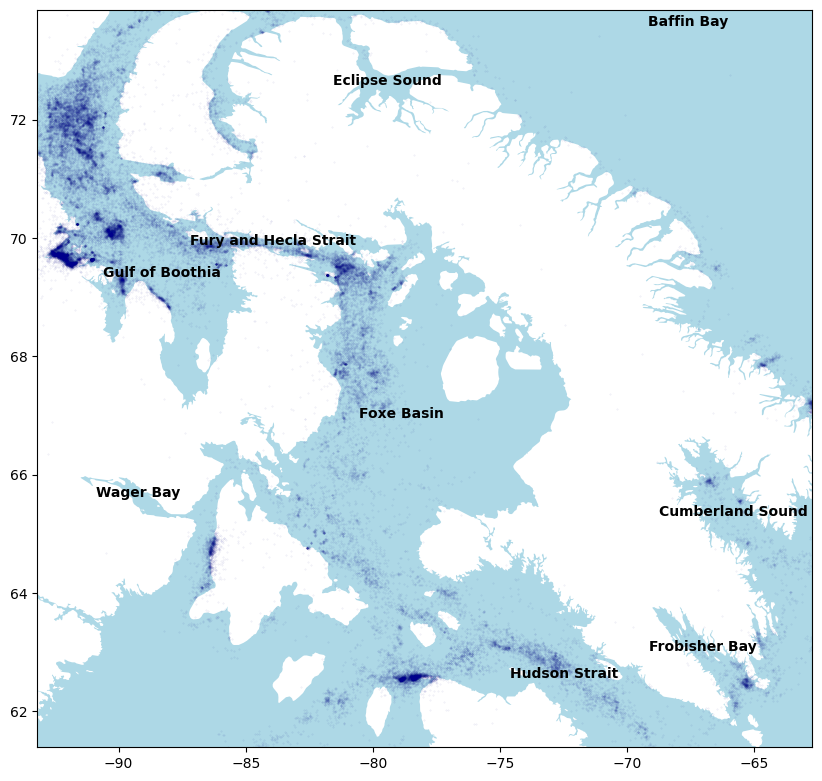

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
shp_ocean.plot(ax=ax, aspect=2, color="lightblue")
shp_whale.plot(ax=ax, color="darkblue", markersize=0.1, alpha=0.1)
shp_ocean_label.dropna(subset="name").apply(
    lambda x: ax.annotate(
        text=x["name"], xy=x.geometry.centroid.coords[0], ha="center", weight="bold"
    ),
    axis=1,
)
ax.set_xlim(west, east)
ax.set_ylim(south, north)

In [6]:
shp_whale_ocean = gpd.sjoin(shp_whale, shp_ocean, how="inner", predicate="intersects")
print(
    f"Percentage of points inside body of water: {len(shp_whale_ocean)/len(shp_whale)*100:.2f}%"
)

Percentage of points inside body of water: 93.57%


(61.39402, 73.85266)

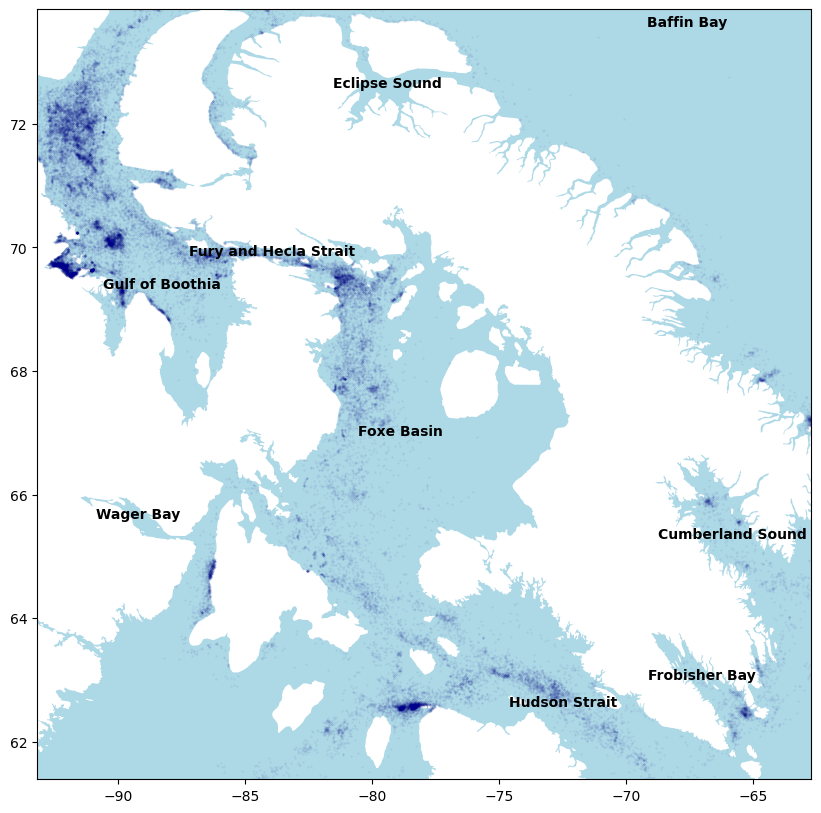

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
shp_ocean.plot(ax=ax, aspect=2, color="lightblue")
shp_whale_ocean.plot(ax=ax, color="darkblue", markersize=0.1, alpha=0.1)
shp_ocean_label.dropna(subset="name").apply(
    lambda x: ax.annotate(
        text=x["name"], xy=x.geometry.centroid.coords[0], ha="center", weight="bold"
    ),
    axis=1,
)
ax.set_xlim(west, east)
ax.set_ylim(south, north)

In [8]:
shp_whale_ocean.head()

,event-id,visible,timestamp,location-long,location-lat,argos:lc,sensor-type,individual-taxon-canonical-name,tag-local-identifier,individual-local-identifier,study-name,geometry,index_right,featurecla,scalerank,min_zoom
0,12050479215,True,2011-07-19 16:18:00,-81.525,69.517,1,argos-doppler-shift,Balaena mysticetus,39161,39161,Bowhead whale Foxe Basin,POINT (-81.52500 69.51700),0,Ocean,0,0
1,12050479216,True,2011-07-19 16:36:00,-81.465,69.523,2,argos-doppler-shift,Balaena mysticetus,39161,39161,Bowhead whale Foxe Basin,POINT (-81.46500 69.52300),0,Ocean,0,0
2,12050479217,True,2011-07-19 17:12:00,-81.473,69.512,3,argos-doppler-shift,Balaena mysticetus,39161,39161,Bowhead whale Foxe Basin,POINT (-81.47300 69.51200),0,Ocean,0,0
3,12050479218,True,2011-07-19 17:18:00,-81.477,69.515,2,argos-doppler-shift,Balaena mysticetus,39161,39161,Bowhead whale Foxe Basin,POINT (-81.47700 69.51500),0,Ocean,0,0
4,12050479219,True,2011-07-19 17:19:00,-81.478,69.516,3,argos-doppler-shift,Balaena mysticetus,39161,39161,Bowhead whale Foxe Basin,POINT (-81.47800 69.51600),0,Ocean,0,0


# of Cluster: 18


<Axes: ylabel='$\\lambda$ value'>

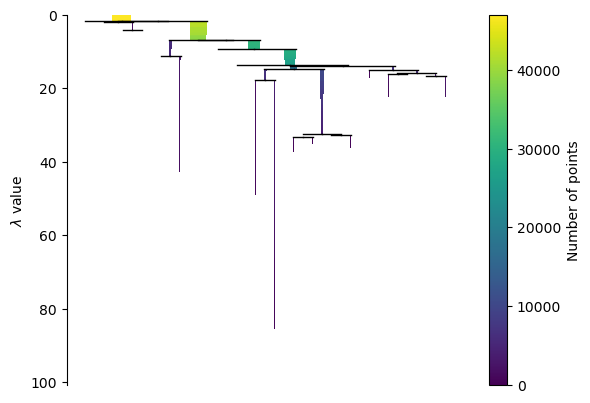

In [50]:
hdb_fit = hdbscan.HDBSCAN(min_cluster_size=500, min_samples=10)
hdb_fit.fit(shp_whale_ocean[["location-long", "location-lat"]])
shp_whale_ocean["clu_hdbscan"] = [str(x) for x in hdb_fit.labels_]
print(f"# of Cluster: {len(shp_whale_ocean['clu_hdbscan'].unique())}")
hdb_fit.condensed_tree_.plot()

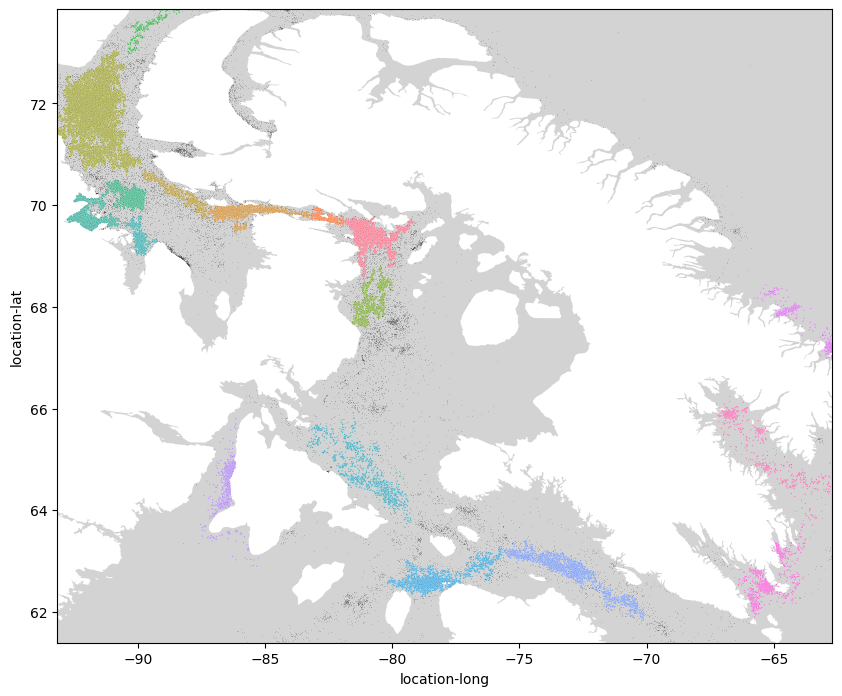

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
shp_ocean.plot(ax=ax, aspect=2, color="lightgrey")
sns.scatterplot(
    data=shp_whale_ocean[shp_whale_ocean["clu_hdbscan"] != "-1"],
    x="location-long",
    y="location-lat",
    hue="clu_hdbscan",
    s=1,
)
sns.scatterplot(
    data=shp_whale_ocean[shp_whale_ocean["clu_hdbscan"] == "-1"],
    x="location-long",
    y="location-lat",
    color="black",
    s=0.1,
)
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.get_legend().remove()

In [52]:
shp_whale_ocean = shp_whale_ocean.sort_values(
    ["individual-local-identifier", "timestamp"]
).reset_index(drop=True)
shp_whale_ocean["season"] = shp_whale_ocean["timestamp"].dt.month % 12 // 3 + 1
shp_whale_ocean["date"] = shp_whale_ocean["timestamp"].dt.date
shp_whale_ocean["day_of_year"] = shp_whale_ocean["timestamp"].dt.dayofyear

Text(0.5, 0.98, 'Time Distribution of Observations for 114495')

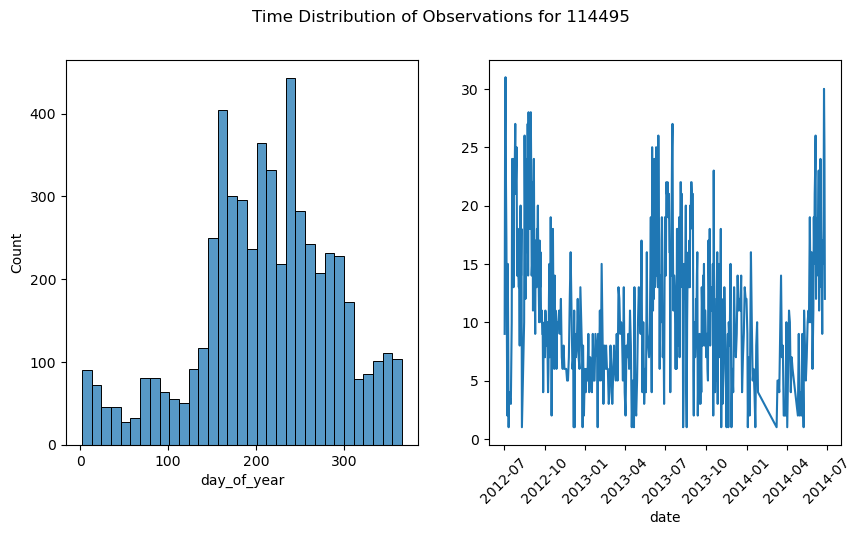

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(
    data=shp_whale_ocean[shp_whale_ocean["individual-local-identifier"] == 114495],
    x="day_of_year",
    ax=ax[0],
)
shp_whale_ocean[shp_whale_ocean["individual-local-identifier"] == 114495].groupby(
    "date"
)["timestamp"].count().plot(ax=ax[1])
[x.set_rotation(45) for x in ax[1].get_xticklabels()]
fig.suptitle("Time Distribution of Observations for 114495")

In [54]:

shp_whale_ocean["timestep"] = shp_whale_ocean.groupby("individual-local-identifier")[
    "timestamp"
].diff() / pd.Timedelta(hours=1)
shp_whale_ocean.loc[shp_whale_ocean["timestep"] < 24, "timestep_corr"] = shp_whale_ocean["timestep"]
shp_whale_ocean.loc[shp_whale_ocean["timestep"] >= 24, "timestep_corr"] = 24

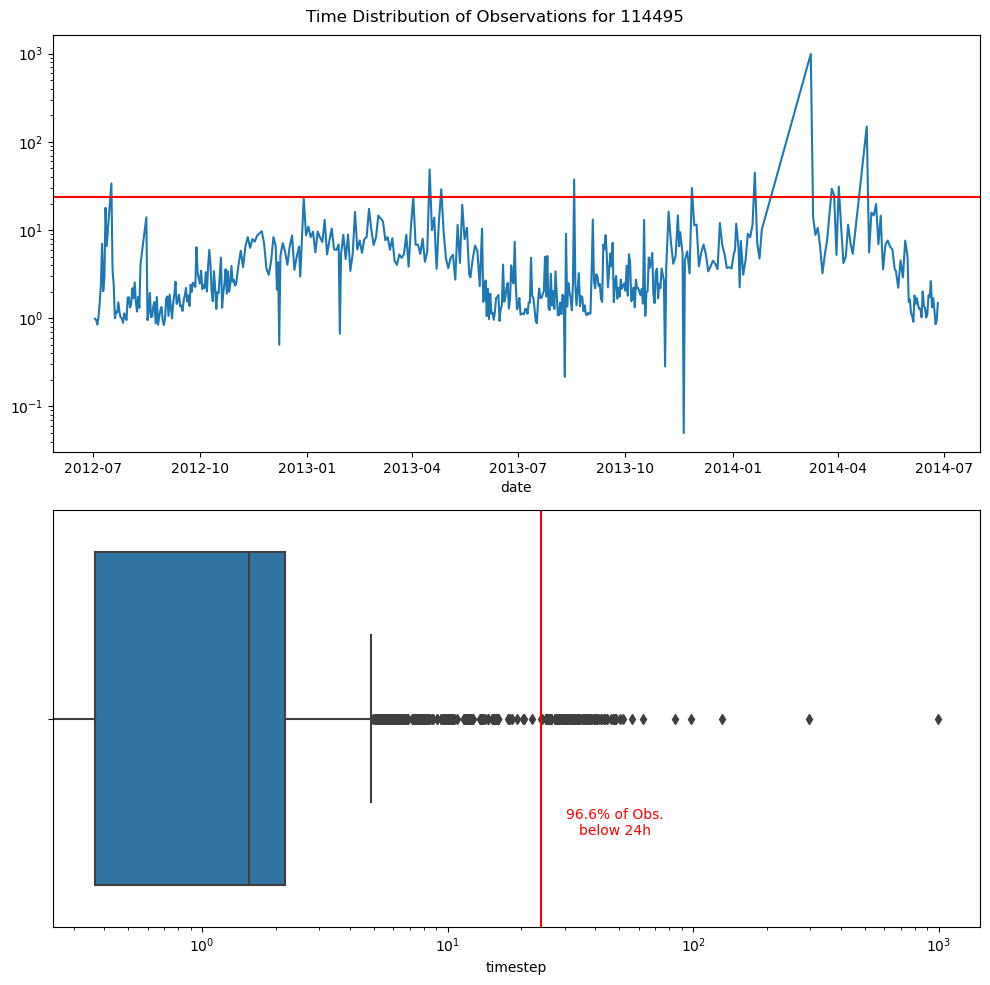

In [55]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
shp_whale_ocean[shp_whale_ocean["individual-local-identifier"] == 114495].groupby(
    "date"
)["timestep"].mean().plot(ax=ax[0])
ax[0].set_yscale("log")
ax[0].axhline(24, color="red", label="24 hours")
sns.boxplot(
    data=shp_whale_ocean[shp_whale_ocean["individual-local-identifier"] == 114495],
    x="timestep",
    ax=ax[1],
)
ax[1].set_xscale("log")
ax[1].axvline(24, color="red", label="24 hours")
p24 = np.round(
    sp.stats.percentileofscore(
        shp_whale_ocean.loc[
            shp_whale_ocean["individual-local-identifier"] == 114495, "timestep"
        ].dropna(),
        24,
    ),
    1,
)
ax[1].annotate(
    f"{p24}% of Obs.\nbelow 24h", xy=(48, 0.25), ha="center", va="center", color="red"
)
fig.suptitle("Time Distribution of Observations for 114495")
fig.tight_layout()

In [56]:
shp_whale_ocean["cluster"] = shp_whale_ocean["clu_hdbscan"].replace("-1", pd.NA)

In [57]:
shp_whale_ocean["interp_cluster"] = (
    shp_whale_ocean.groupby("individual-local-identifier")["cluster"]
    .apply(lambda group: group.interpolate(method="bfill"))
    .reset_index(drop=True)
)

shp_whale_ocean["prev_cluster"] = shp_whale_ocean.groupby(
    "individual-local-identifier"
)["interp_cluster"].shift(1)

shp_whale_ocean_nout = (
    shp_whale_ocean[shp_whale_ocean["clu_hdbscan"] != "-1"]
    .copy()
    .sort_values(["individual-local-identifier", "timestamp"])
)

shp_whale_ocean_nout["sil_score"] = silhouette_samples(
    shp_whale_ocean_nout[["location-long", "location-lat"]],
    shp_whale_ocean_nout["clu_hdbscan"],
)

In [58]:
tb_clu_position = (
    shp_whale_ocean_nout.sort_values(["clu_hdbscan", "sil_score"], ascending=False)
    .groupby("clu_hdbscan")
    .first()[["location-long", "location-lat"]]
    .rename(columns={"location-long": "long", "location-lat": "lat"})
    .merge(
        shp_whale_ocean_nout.groupby("clu_hdbscan")["timestep_corr"].sum().reset_index(),
        on = "clu_hdbscan"
    )
)

In [60]:
tb_trans = pd.crosstab(
    shp_whale_ocean_nout.loc[:, "clu_hdbscan"],
    shp_whale_ocean_nout.loc[:, "prev_cluster"],
    normalize="columns",
)
trans_mat = tb_trans.values
trans_mat_index = tb_trans.index
trans_mat_col = tb_trans.columns

tb_trans_long = (
    tb_trans.reset_index()
    .melt(id_vars="clu_hdbscan")
    .rename(
        {"clu_hdbscan": "from_cluster", "prev_cluster": "to_cluster", "value": "prob"},
        axis=1,
    )
    .query("prob>0.000000001")
)


tb_trans_pos = (
    tb_trans_long.merge(tb_clu_position, left_on="from_cluster", right_on = "clu_hdbscan")
    .rename(columns={"lat": "from_lat", "long": "from_long"})
    .merge(tb_clu_position, left_on="to_cluster", right_on = "clu_hdbscan")
    .rename(columns={"lat": "to_lat", "long": "to_long"})
    .query("from_cluster != to_cluster")
)

tb_trans_pos["prob_cond"] = tb_trans_pos["prob"] / tb_trans_pos.groupby("from_cluster")[
    "prob"
].transform("sum")

In [61]:
tb_trans.values.diagonal()

array([1.        , 1.        , 0.99251637, 0.98296199, 0.99366008,
       0.96660808, 0.93426573, 0.92557252, 0.98742138, 0.99674267,
       0.99791232, 1.        , 0.99427083, 0.99750312, 0.9980198 ,
       0.98901099, 0.99814399])

(60.39402, 73.85266)

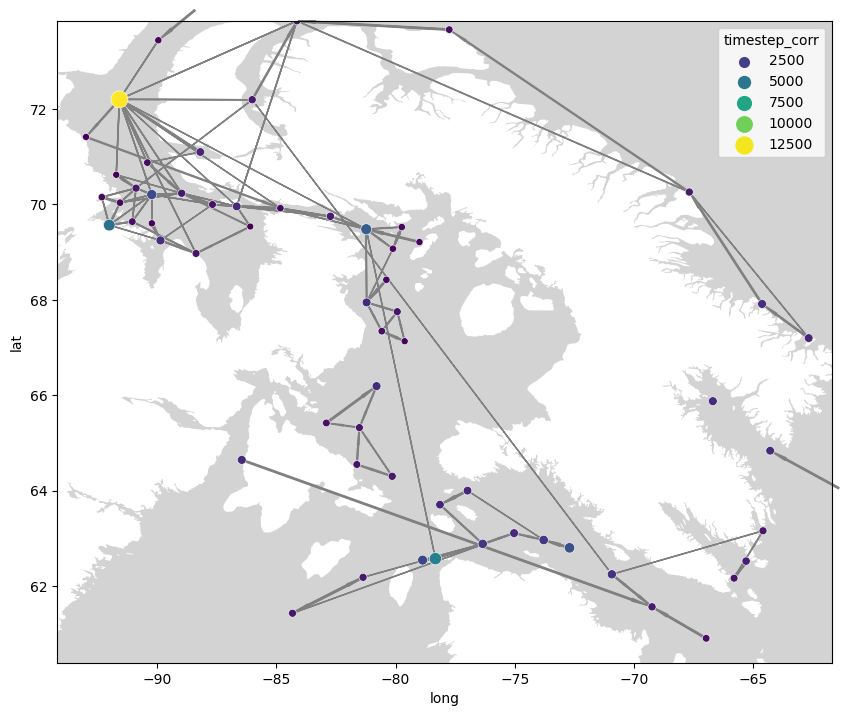

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
shp_ocean.plot(ax=ax, aspect=2, color="lightgrey")
sns.scatterplot(
    data=tb_clu_position,
    x="long",
    y="lat",
    size="timestep_corr",
    sizes = (25, 150),
    hue = "timestep_corr",
    palette = "viridis",
    zorder =2
)
for annot in tb_trans_pos.iterrows():
    ax.annotate(
        text="",
        xy=(annot[1]["to_long"], annot[1]["to_lat"]),
        xytext=(annot[1]["from_long"], annot[1]["from_lat"]),
        ha="center",
        va="center",
        color="darkgrey",
        arrowprops=dict(
            facecolor="grey",
            edgecolor="grey",
            shrink=0.01,
            width=annot[1]["prob_cond"],
            headwidth=annot[1]["prob_cond"]*2
        ),
        zorder = 1
    )
ax.set_xlim(west-1, east+1)
ax.set_ylim(south-1, north)

In [ ]:
for n_clu in tb_trans_pos["from_cluster"].unique():
    fig, ax = plt.subplots(figsize=(10, 10))
    shp_ocean.plot(ax=ax, aspect=2, color="lightblue")
    shp_whale_ocean.plot(ax=ax, color="darkblue", markersize=0.1, alpha=0.1)
    for annot in tb_trans_pos[tb_trans_pos["from_cluster"] == n_clu].iterrows():
        ax.annotate(
            text="",
            xy=(annot[1]["to_long"], annot[1]["to_lat"]),
            xytext=(annot[1]["from_long"], annot[1]["from_lat"]),
            ha="center",
            va="center",
            color="red",
            arrowprops=dict(
                facecolor="red",
                edgecolor="red",
                shrink=0.05,
                width=annot[1]["prob_cond"] * 10,
            ),
        )
    shp_ocean_label.dropna(subset="name").apply(
        lambda x: ax.annotate(
            text=x["name"], xy=x.geometry.centroid.coords[0], ha="center", weight="bold"
        ),
        axis=1,
    )
    ax.set_xlim(west, east)
    ax.set_ylim(south, north)
    ax.set_title(f"Transition Probabilities for Cluster {n_clu}")
    fig.savefig(f"output_graph/transition/transition_prob_from_{n_clu}.png", dpi=300)

In [ ]:
val, vec = np.linalg.eig(trans_mat)